<a href="https://colab.research.google.com/github/VCosmo/POLOSA/blob/main/PPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from gal4H0 import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import erf
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy

import seaborn as sns
pal=sns.color_palette('colorblind')

import matplotlib as _mpl

_mpl.rcParams['figure.figsize']= (3.3, 2.5)
_mpl.rcParams['figure.dpi']= 300
_mpl.rcParams['axes.labelsize']= 7
_mpl.rcParams['xtick.labelsize']= 7
_mpl.rcParams['ytick.labelsize']= 7
_mpl.rcParams['legend.fontsize']= 7
_mpl.rcParams['font.size']= 7
_mpl.rcParams['font.family']= 'sans-serif'
_mpl.rcParams['font.sans-serif']= ['DejaVu Sans', 'Arial', 'Helvetica', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']
_mpl.rcParams['mathtext.fontset']='dejavusans'
_mpl.rcParams['axes.linewidth']= 0.5
_mpl.rcParams['grid.linewidth']= 0.5
_mpl.rcParams['lines.linewidth']= 1.
_mpl.rcParams['lines.markersize']= 3.
_mpl.rcParams['savefig.bbox']= 'tight'
_mpl.rcParams['savefig.pad_inches']= 0.01
#mpl.rcParams['text.latex.preamble']= '\usepackage{amsmath, amssymb, sfmath}'

def normal_distribution(x,mu,sigma):
    '''
    Reuturns a simple gaussian likelihood:
    
    Parameters
    ----------
    x: np.array
        Where to evaluate likelihood
    mu,sigma: np.array
        Mean and standard deviation of gaussian
    '''
    var=sigma**2
    return np.power(2*np.pi*var,-0.5)*np.exp(-0.5*np.power((x-mu)/sigma,2.))

def normal_distribution_inco(x,mu,sigma):
    '''
    Reuturns a gaussian likelihood without overall normalization:
    
    Parameters
    ----------
    x: np.array
        Where to evaluate likelihood
    mu,sigma: np.array
        Mean and standard deviation of gaussian
    '''
    var=sigma**2
    return np.exp(-0.5*np.power((x-mu)/sigma,2.))

def GW_detection_probability(dltrue,sigmadl,dlthr):
    '''z
    Return a detection probability given a gaussian likelihood. The detection probability is defined as 
    the integral from -inf to x_thr of a given normal distribution with mean mu and std.
    
    Parameters
    ----------
    dltrue: np.array
        Where to evaluate the det prob
    sigmadl: np.array
        std of the likelihood model
    dlthr: np.array
        Cut for the selection
    '''
    t_thr= (dlthr-dltrue)/sigmadl # Normalized random variable
    return 0.5*(1+erf(t_thr/np.sqrt(2)))

def GW_detection_probability_Heaviside(dltrue,dlthr):
    '''
    A GW detection probability that is a Heaviside step function 
    
    Parameters
    ----------
    dltrue: np.array
        Where to evaluate the det prob
    dlthr: np.array
        Cut for the selection
    '''
    
    out=np.ones_like(dltrue)
    out[dltrue>dlthr]=0.
    return out

def replicate_galaxies(galaxies_list,Ntot=100000,scatter=0.001):
    '''
    This function replicate a list of true redshift of galaxies adding on top some scatter
    
    Parameters
    ----------
    galaxies_list: np.array
        True redshift of galaxies
    Ntot: int
        How many galaxies you want, the code will round the number of clones to generate
    scatter: float
        what is the fractional scatter
    '''
    Nrep=int(np.ceil(Ntot/len(galaxies_list)))
    
    clones=[]
    for i in range(Nrep):
        clones.append((np.random.randn(len(galaxies_list))*scatter+1.)*galaxies_list)
    
    clones=np.hstack(clones)
    return np.hstack([galaxies_list,clones])
    


def build_interpolant(z_obs,sigmazevalobs,zrate,nocom='dvcdz'):
    '''
    This function returns the p(z|c) interpolator assuming constant rate
    
    Parameters
    ----------
    z_obs: array
        List of observed values for galaxies
    z_rate: float
        Maximum redshift for the rate
    '''
    
    zinterpolant=np.exp(np.linspace(np.log(1e-4),np.log(zrate),80000))
    
    interpolant=np.zeros_like(zinterpolant)
    cosmo=FlatLambdaCDM(H0=70.,Om0=0.25)
    sigmaz=0.013*np.power(1+zinterpolant,3.)
    sigmaz[sigmaz>0.015]=0.015
       
    # This is the prior to applied to the interpolant 
    if nocom=='uniform':
        dvcdz_ff=1.
    elif nocom=='dvcdz':
        dvcdz_ff=cosmo.differential_comoving_volume(zinterpolant).value
    else:
        gkde=scipy.stats.gaussian_kde(nocom,bw_method=0.8e-1)
        dvcdz_ff=gkde(interpolant)
        
 
    for i in tqdm(range(len(z_obs))):
        # Initializes array for the calculation of the interpolant
        zmin=np.max([0.,z_obs[i]-5*sigmazevalobs[i]])
        zeval=np.linspace(zmin,z_obs[i]+5*sigmazevalobs[i],5000)
        sigmazeval=0.013*np.power(1+zeval,3.)
        sigmazeval[sigmazeval>0.015]=0.015
        
        if nocom=='uniform':
            dvcdz=1.
        elif nocom=='dvcdz':
            dvcdz=cosmo.differential_comoving_volume(zeval).value
        else:
            dvcdz=gkde(zeval)
        
        # The line below is the redshift likelihood times the prior.
        pval=normal_distribution(zeval,mu=z_obs[i],sigma=sigmazeval)*dvcdz
        normfact=scipy.integrate.simpson(pval,zeval) # Renormalize        
        evals=normal_distribution(zinterpolant,mu=z_obs[i],sigma=sigmaz)*dvcdz_ff/normfact
        
        if np.all(np.isnan(evals)):
            continue
        interpolant+=evals # Sum to create the interpolant
    interpolant/=scipy.integrate.simpson(interpolant,zinterpolant)
    return interp1d(zinterpolant,np.log(interpolant),bounds_error=False,fill_value=-np.inf),zinterpolant

def draw_gw_events(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate):
    '''
    This function draws the GW events and applies a selection based on the observed luminosity distance
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    # M = abs.magn.; m = apparent magn.; d= distance in Mpc
    Ngw=100000 # Just a random number high enough to have detections
    
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
     # Draw randomly from the galaxy list, takes into account also a rate cut
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=(rate_term/rate_term.sum())*np.power(L, alfa)) #p is the prob. associated to every element of the array
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl # Defines the sigma for the gaussian
    gw_obs_dl=np.random.randn(len(gw_true_dl))*std_dl+gw_true_dl # Generate an observed value, a.k.a. data
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0] # Finds the detected GW events
    gw_detected = gw_detected[:Ndet:] # Takes the first Ndet GW events detected
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]

def M2m(M,dl):
    '''
    Converts Absolute bolometric magnitude to apparent magnitude
   
    Parameters
    ----------
    M: np.array
        Absolute bolometric magnitude
    dl: np.array
        Luminosity distance in Mpc
   
    Returns
    -------
    m: np.array
        Apparent magnitude
    '''
  # Note that the distance is Mpc here. See Eq. 2 of https://arxiv.org/abs/astro-ph/0210394
    dist_modulus=5*np.log10(dl)+25.
    return M+dist_modulus


def m2M(m,dl):
    '''
    Converts apparent magnitude to Absolute bolometric magnitude
   
    Parameters
    ----------
    m: np.array
        apparebt magnitude
    dl: np.array
        Luminosity distance in Mpc

   
    Returns
    -------
    M: np.array
        Absolute bolometric magnitude
    '''
    # Note that the distance is Mpc here. See Eq. 2 of https://arxiv.org/abs/astro-ph/0210394
    dist_modulus=5*np.log10(dl)+25.
    return m-dist_modulus



def L2M(L):
    '''
    Converts Luminosity in Watt to Absolute bolometric magnitude
   
    Parameters
    ----------
    L: np.array
        Luminosity in Watt
   
    Returns
    -------
    M: np.array
        Absolute bolometric magnitude
    '''
    # From Resolution B2 proposed by IAU, see e.g. Pag. 2, Eq. 2 of https://www.iau.org/static/resolutions/IAU2015_English.pdf
    return -2.5*np.log10(L)+71.197425

def M2L(M):
    '''
    Converts Absolute bolometric magnitude to Luminosity in Watt
   
    Parameters
    ----------
    M: np.array
        Absolute bolometric magnitude
   
    Returns
    -------
    L: np.array
        Luminosity in Watt
    '''
    # From Pag. 2, Eq. 1-2 of https://www.iau.org/static/resolutions/IAU2015_English.pdf
    return 3.0128e28*np.power(10.,-0.4*M)

def draw_gw_events_L(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate, L, alpha):
    '''
    This function draws the GW events and applies a selection based on the observed luminosity distance
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    # M = abs.magn.; m = apparent magn.; d= distance in Mpc
    Ngw=100000 # Just a random number high enough to have detections
    
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
    rate_term*=np.power(L, alpha)
     # Draw randomly from the galaxy list, takes into account also a rate cut
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) #p is the prob. associated to every element of the array
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl # Defines the sigma for the gaussian
    gw_obs_dl=np.random.randn(len(gw_true_dl))*std_dl+gw_true_dl # Generate an observed value, a.k.a. data
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0] # Finds the detected GW events
    gw_detected = gw_detected[:Ndet:] # Takes the first Ndet GW events detected
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]

def draw_gw_events_inco(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate):
    '''
    This function draws the GW events and applies a double counting on p(z).
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    Ngw=100000 # Just a random number high enough to have detections
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) # Draw from galaxies according to rate
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl
    gw_obs_dl=gw_true_dl
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0]
    gw_detected = gw_detected[:Ndet:]
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]


def galaxy_catalog_analysis_accurate_redshift(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis in the limit that the redshift estimate from the catalog
    is without uncertainties
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    galaxies_list: array with the redshift of the galaxies
    zcut_rate: until what redshift GW events to happen
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''
    
    
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    rate_term = np.zeros_like(galaxies_list)
    rate_term[galaxies_list<=zcut_rate]=1.
    p_z_given_C=rate_term/rate_term.sum() # Calculates what galaxies have a non-zero rate
    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    dltimesH0=cosmotrial.luminosity_distance(galaxies_list).to('Mpc').value*cosmotrial.H0.value # Initialize dltimes H0

    for j,H0 in tqdm(enumerate(H0_array),desc='running on H0'):
        dltrial=dltimesH0/H0 # Calculations of dl
        
        # Selection bias
        selection_bias=np.sum(GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*p_z_given_C)
        for i,idx in enumerate(gw_obs_dl):
            # Integral at the numerator (it is a sum since we measure perfectly redshift)
            numerator = np.sum(normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*p_z_given_C)
            posterior_matrix[i,j]=numerator/selection_bias

    # Normalize and combine posteriors
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)
        
    return posterior_matrix,combined

def galaxy_catalog_analysis_accurate_redshift_L(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr, m, alpha):
    '''
    This function will perform the H0 analysis in the limit that the redshift estimate from the catalog
    is without uncertainties
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    galaxies_list: array with the redshift of the galaxies
    zcut_rate: until what redshift GW events to happen
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''
    
    
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    rate_term = np.zeros_like(galaxies_list)
    rate_term[galaxies_list<=zcut_rate]=1.
    p_z_given_C=rate_term/rate_term.sum() # Calculates what galaxies have a non-zero rate
    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    dltimesH0=cosmotrial.luminosity_distance(galaxies_list).to('Mpc').value*cosmotrial.H0.value # Initialize dltimes H0

    for j,H0 in tqdm(enumerate(H0_array),desc='running on H0'):
        dltrial=dltimesH0/H0 # Calculations of dl
        Labs=M2L(m2M(m, dltrial))/1e47
        # Selection bias
        selection_bias=np.sum(GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*p_z_given_C*np.power(Labs, alpha))
        for i,idx in enumerate(gw_obs_dl):
            # Integral at the numerator (it is a sum since we measure perfectly redshift)
            numerator = np.sum(normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*p_z_given_C*np.power(Labs, alpha))
            posterior_matrix[i,j]=numerator/selection_bias

    # Normalize and combine posteriors
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)
        
    return posterior_matrix,combined

def galaxy_catalog_analysis_photo_redshift_inco(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on galaxy redshift but INCORRETLY using and Heaviside step function as GW detection probability.
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability_Heaviside(dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined


# def galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
#     '''
#     This function will perform the H0 analysis assuming errors on the redshift determination.
    
#     Parameters
#     ---------
#     H0_array: grid of H0 for the analysis
#     zinterpo: Interpolant for p(z|C)
#     gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
#     sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
#     dl_thr: Threshold for detection in Mpc
    
#     Returns
#     -------
#     Posterior matrix (raws events, columns H0) and combined posterior
#     '''

#     cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
#     posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
#     # Evaluated d_L times H0
#     dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    
#     funcinv=interp1d(dltimesH0,zinterpo.x,fill_value=np.inf,bounds_error=False)
       
#     selection_bias=np.zeros_like(H0_array)
#     pzeval=zinterpo(zinterpo.x)
    
    
#     # Calculate the selection effect on the grid just once
#     for j,H0 in tqdm(enumerate(H0_array)):
#         dltrial=dltimesH0/H0
#         integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
#         selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
#     # Loop on the GW events and H0 to compute posteriors
#     for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
#         dltrial=np.linspace(np.max([0,gw_obs_dl[i]*(1-5*sigma_dl)]),gw_obs_dl[i]*(1+10*sigma_dl),50000)
#         for j,H0 in enumerate(H0_array):
#             zvals=funcinv(dltrial*H0)
#             idx=np.where(zvals!=np.inf)[0]
#             integrand=normal_distribution(gw_obs_dl[i],mu=dltrial[idx],sigma=sigma_dl*dltrial[idx])*zinterpo(zvals[idx])
#             # Do the integral of the numerator in redshift
#             numerator = scipy.integrate.simpson(integrand,zvals[idx])
#             posterior_matrix[i,j]=numerator/selection_bias[j]
            
#     # Combine the result
#     combined=np.ones_like(H0_array)
#     for i,idx in enumerate(gw_obs_dl):
#         posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
#         combined*=posterior_matrix[i,:]
#         combined/=scipy.integrate.simpson(combined,H0_array)

#     return posterior_matrix,combined


def galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on the redshift determination.
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined
                
                

        
def galaxy_catalog_analysis_photo_redshift_GWlikelihood_inconsistency(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on the redshift determination and no normalization in the luminosity distance
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability_Heaviside(dltrial,dlthr=dl_thr)*pzeval
        #integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution_inco(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined

In [2]:
import pickle
from scipy.integrate import cumtrapz
import scipy

In [3]:
cosmo=FlatLambdaCDM(H0=70.,Om0=0.25)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import pandas as pd
# Define the path to the catalog compressed CSV file:
catalog_filename = "/content/drive/MyDrive/13826.csv.bz2"  
# Define the list of columns that uniquely identify each row
data = pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2')
abs_M=data['abs_mag_r'].to_numpy()[0:1000:]
galaxies_list=data['z'].to_numpy()[0:1000:]
Labs=M2L(abs_M)
app_m=M2m(abs_M, cosmo.luminosity_distance(galaxies_list).to('Mpc').value)
print(len(app_m))

1000


In [32]:
import os, sys
sys.path.append('../')

np.random.seed(0)

filename=['6_0_10perc_acc.p' ,'6_1_10perc_acc.p' ,'6_2_10perc_acc.p']

beta=1
betas=[beta-1, beta, beta+1]

Ngw=100
sigma_dl=0.1
zcut_rate=1.4
dl_thr=1550
H0_array=np.linspace(40,120,2000)
Nrep=20

for j in range(3):

  output={'H0_grid':H0_array,
       'single_pos':[],
       'true_H0':np.zeros(Nrep)}

  for ii in tqdm(range(Nrep)):
    output['true_H0'][ii]=np.random.uniform(40,120,size=1)
    true_cosmology = FlatLambdaCDM(H0=output['true_H0'][ii],Om0=0.25)
    gw_obs_dl,_,_,std_dl=draw_gw_events_L(Ngw,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate, Labs, beta)
    posterior_matrix,combined=galaxy_catalog_analysis_accurate_redshift_L(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr,app_m,betas[j])
    output['single_pos'].append(posterior_matrix)
    
  pickle.dump(output,open(filename[j],'wb'))

  0%|          | 0/20 [00:00<?, ?it/s]

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 88.86it/s]
running on H0: 18it [00:00, 84.64it/s]
running on H0: 27it [00:00, 84.19it/s]
running on H0: 36it [00:00, 81.31it/s]
running on H0: 45it [00:00, 82.81it/s]
running on H0: 54it [00:00, 84.23it/s]
running on H0: 63it [00:00, 85.44it/s]
running on H0: 72it [00:00, 86.31it/s]
running on H0: 81it [00:00, 86.25it/s]
running on H0: 90it [00:01, 81.88it/s]
running on H0: 99it [00:01, 83.18it/s]
running on H0: 108it [00:01, 83.77it/s]
running on H0: 117it [00:01, 82.72it/s]
running on H0: 126it [00:01, 84.01it/s]
running on H0: 135it [00:01, 85.55it/s]
running on H0: 144it [00:01, 86.64it/s]
running on H0: 153it [00:01, 87.20it/s]
running on H0: 162it [00:01, 86.24it/s]
running on H0: 171it [00:02, 85.15it/s]
running on H0: 180it [00:02, 83.32it/s]
running on H0: 189it [00:02, 83.55it/s]
running on H0: 198it [00:02, 84.06it/s]
running on H0: 207it [00:02, 81.67it/s]
running on H0: 216it [00:02, 82.01it/s]
running on H0: 22

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 88.10it/s]
running on H0: 18it [00:00, 78.48it/s]
running on H0: 26it [00:00, 77.45it/s]
running on H0: 34it [00:00, 75.86it/s]
running on H0: 43it [00:00, 79.53it/s]
running on H0: 52it [00:00, 80.21it/s]
running on H0: 61it [00:00, 81.19it/s]
running on H0: 70it [00:00, 80.35it/s]
running on H0: 79it [00:00, 80.21it/s]
running on H0: 88it [00:01, 80.51it/s]
running on H0: 97it [00:01, 81.49it/s]
running on H0: 106it [00:01, 80.56it/s]
running on H0: 115it [00:01, 81.97it/s]
running on H0: 124it [00:01, 82.64it/s]
running on H0: 133it [00:01, 83.64it/s]
running on H0: 142it [00:01, 84.56it/s]
running on H0: 151it [00:01, 84.66it/s]
running on H0: 160it [00:01, 84.17it/s]
running on H0: 169it [00:02, 82.15it/s]
running on H0: 178it [00:02, 82.89it/s]
running on H0: 187it [00:02, 80.50it/s]
running on H0: 196it [00:02, 81.50it/s]
running on H0: 205it [00:02, 82.85it/s]
running on H0: 214it [00:02, 83.64it/s]
running on H0: 22

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 87.16it/s]
running on H0: 18it [00:00, 82.52it/s]
running on H0: 27it [00:00, 76.67it/s]
running on H0: 35it [00:00, 76.34it/s]
running on H0: 44it [00:00, 79.05it/s]
running on H0: 53it [00:00, 80.61it/s]
running on H0: 62it [00:00, 82.36it/s]
running on H0: 71it [00:00, 81.26it/s]
running on H0: 80it [00:00, 82.65it/s]
running on H0: 89it [00:01, 82.77it/s]
running on H0: 98it [00:01, 80.48it/s]
running on H0: 107it [00:01, 80.08it/s]
running on H0: 116it [00:01, 79.00it/s]
running on H0: 125it [00:01, 81.03it/s]
running on H0: 134it [00:01, 80.71it/s]
running on H0: 143it [00:01, 81.50it/s]
running on H0: 152it [00:01, 81.55it/s]
running on H0: 161it [00:01, 82.59it/s]
running on H0: 170it [00:02, 83.26it/s]
running on H0: 179it [00:02, 80.59it/s]
running on H0: 188it [00:02, 79.85it/s]
running on H0: 197it [00:02, 75.05it/s]
running on H0: 206it [00:02, 77.04it/s]
running on H0: 214it [00:02, 77.33it/s]
running on H0: 22

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 10it [00:00, 92.99it/s]
running on H0: 20it [00:00, 85.79it/s]
running on H0: 29it [00:00, 84.32it/s]
running on H0: 38it [00:00, 83.87it/s]
running on H0: 47it [00:00, 81.46it/s]
running on H0: 56it [00:00, 81.76it/s]
running on H0: 65it [00:00, 81.50it/s]
running on H0: 74it [00:00, 82.16it/s]
running on H0: 83it [00:01, 82.61it/s]
running on H0: 92it [00:01, 83.27it/s]
running on H0: 101it [00:01, 82.88it/s]
running on H0: 110it [00:01, 82.37it/s]
running on H0: 119it [00:01, 82.85it/s]
running on H0: 128it [00:01, 79.72it/s]
running on H0: 137it [00:01, 81.33it/s]
running on H0: 146it [00:01, 82.60it/s]
running on H0: 155it [00:01, 81.57it/s]
running on H0: 164it [00:01, 81.23it/s]
running on H0: 173it [00:02, 81.99it/s]
running on H0: 182it [00:02, 82.79it/s]
running on H0: 191it [00:02, 82.84it/s]
running on H0: 200it [00:02, 79.74it/s]
running on H0: 209it [00:02, 80.50it/s]
running on H0: 218it [00:02, 79.42it/s]
running on H0: 

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 89.65it/s]
running on H0: 18it [00:00, 85.32it/s]
running on H0: 27it [00:00, 74.64it/s]
running on H0: 35it [00:00, 74.51it/s]
running on H0: 43it [00:00, 73.87it/s]
running on H0: 51it [00:00, 74.34it/s]
running on H0: 59it [00:00, 75.67it/s]
running on H0: 67it [00:00, 73.74it/s]
running on H0: 75it [00:00, 74.51it/s]
running on H0: 83it [00:01, 74.70it/s]
running on H0: 91it [00:01, 75.20it/s]
running on H0: 99it [00:01, 76.52it/s]
running on H0: 108it [00:01, 78.23it/s]
running on H0: 117it [00:01, 79.73it/s]
running on H0: 125it [00:01, 77.70it/s]
running on H0: 133it [00:01, 78.35it/s]
running on H0: 142it [00:01, 80.20it/s]
running on H0: 151it [00:01, 81.43it/s]
running on H0: 160it [00:02, 81.94it/s]
running on H0: 169it [00:02, 81.64it/s]
running on H0: 178it [00:02, 81.28it/s]
running on H0: 187it [00:02, 80.04it/s]
running on H0: 196it [00:02, 79.34it/s]
running on H0: 204it [00:02, 77.56it/s]
running on H0: 213

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 54.94it/s]
running on H0: 12it [00:00, 48.24it/s]
running on H0: 17it [00:00, 48.48it/s]
running on H0: 23it [00:00, 49.95it/s]
running on H0: 29it [00:00, 50.93it/s]
running on H0: 35it [00:00, 51.53it/s]
running on H0: 42it [00:00, 55.68it/s]
running on H0: 51it [00:00, 64.26it/s]
running on H0: 60it [00:01, 70.56it/s]
running on H0: 69it [00:01, 74.87it/s]
running on H0: 78it [00:01, 78.05it/s]
running on H0: 87it [00:01, 79.51it/s]
running on H0: 96it [00:01, 80.66it/s]
running on H0: 105it [00:01, 81.58it/s]
running on H0: 114it [00:01, 82.27it/s]
running on H0: 123it [00:01, 80.12it/s]
running on H0: 132it [00:01, 79.95it/s]
running on H0: 141it [00:02, 78.00it/s]
running on H0: 149it [00:02, 77.94it/s]
running on H0: 157it [00:02, 78.05it/s]
running on H0: 165it [00:02, 78.46it/s]
running on H0: 174it [00:02, 79.66it/s]
running on H0: 183it [00:02, 80.76it/s]
running on H0: 192it [00:02, 76.97it/s]
running on H0: 201i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 53.61it/s]
running on H0: 12it [00:00, 52.35it/s]
running on H0: 18it [00:00, 51.64it/s]
running on H0: 24it [00:00, 48.24it/s]
running on H0: 29it [00:00, 48.42it/s]
running on H0: 34it [00:00, 46.89it/s]
running on H0: 39it [00:00, 46.96it/s]
running on H0: 44it [00:00, 46.73it/s]
running on H0: 49it [00:01, 47.43it/s]
running on H0: 54it [00:01, 47.64it/s]
running on H0: 60it [00:01, 48.80it/s]
running on H0: 65it [00:01, 47.99it/s]
running on H0: 70it [00:01, 47.21it/s]
running on H0: 75it [00:01, 47.14it/s]
running on H0: 80it [00:01, 47.42it/s]
running on H0: 85it [00:01, 47.35it/s]
running on H0: 90it [00:01, 47.62it/s]
running on H0: 95it [00:01, 48.30it/s]
running on H0: 101it [00:02, 49.49it/s]
running on H0: 106it [00:02, 48.90it/s]
running on H0: 112it [00:02, 49.85it/s]
running on H0: 118it [00:02, 50.30it/s]
running on H0: 124it [00:02, 50.92it/s]
running on H0: 130it [00:02, 51.24it/s]
running on H0: 136it [00

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 69.70it/s]
running on H0: 15it [00:00, 73.23it/s]
running on H0: 24it [00:00, 78.30it/s]
running on H0: 32it [00:00, 66.63it/s]
running on H0: 39it [00:00, 57.72it/s]
running on H0: 46it [00:00, 54.65it/s]
running on H0: 52it [00:00, 52.90it/s]
running on H0: 58it [00:01, 51.78it/s]
running on H0: 64it [00:01, 49.23it/s]
running on H0: 69it [00:01, 48.45it/s]
running on H0: 74it [00:01, 47.70it/s]
running on H0: 79it [00:01, 47.04it/s]
running on H0: 84it [00:01, 46.47it/s]
running on H0: 89it [00:01, 46.75it/s]
running on H0: 94it [00:01, 47.11it/s]
running on H0: 99it [00:01, 47.40it/s]
running on H0: 104it [00:02, 46.78it/s]
running on H0: 109it [00:02, 46.01it/s]
running on H0: 114it [00:02, 41.99it/s]
running on H0: 119it [00:02, 41.23it/s]
running on H0: 124it [00:02, 42.77it/s]
running on H0: 129it [00:02, 43.25it/s]
running on H0: 134it [00:02, 44.81it/s]
running on H0: 139it [00:02, 45.62it/s]
running on H0: 144it [

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 65.69it/s]
running on H0: 15it [00:00, 72.78it/s]
running on H0: 24it [00:00, 77.31it/s]
running on H0: 33it [00:00, 80.17it/s]
running on H0: 42it [00:00, 79.54it/s]
running on H0: 50it [00:00, 77.66it/s]
running on H0: 59it [00:00, 79.43it/s]
running on H0: 67it [00:00, 79.25it/s]
running on H0: 75it [00:00, 78.32it/s]
running on H0: 84it [00:01, 78.75it/s]
running on H0: 92it [00:01, 78.11it/s]
running on H0: 101it [00:01, 80.27it/s]
running on H0: 110it [00:01, 81.22it/s]
running on H0: 119it [00:01, 81.24it/s]
running on H0: 128it [00:01, 82.29it/s]
running on H0: 137it [00:01, 81.77it/s]
running on H0: 146it [00:01, 81.68it/s]
running on H0: 155it [00:01, 83.33it/s]
running on H0: 164it [00:02, 83.15it/s]
running on H0: 173it [00:02, 81.61it/s]
running on H0: 182it [00:02, 81.32it/s]
running on H0: 191it [00:02, 80.30it/s]
running on H0: 200it [00:02, 81.31it/s]
running on H0: 209it [00:02, 81.67it/s]
running on H0: 21

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 77.27it/s]
running on H0: 16it [00:00, 76.91it/s]
running on H0: 24it [00:00, 75.92it/s]
running on H0: 32it [00:00, 75.78it/s]
running on H0: 40it [00:00, 72.40it/s]
running on H0: 48it [00:00, 70.54it/s]
running on H0: 56it [00:00, 73.28it/s]
running on H0: 64it [00:00, 74.00it/s]
running on H0: 72it [00:00, 73.18it/s]
running on H0: 80it [00:01, 74.83it/s]
running on H0: 89it [00:01, 77.02it/s]
running on H0: 97it [00:01, 75.18it/s]
running on H0: 105it [00:01, 76.40it/s]
running on H0: 113it [00:01, 75.64it/s]
running on H0: 121it [00:01, 75.71it/s]
running on H0: 129it [00:01, 71.09it/s]
running on H0: 137it [00:01, 68.72it/s]
running on H0: 144it [00:01, 68.36it/s]
running on H0: 152it [00:02, 69.32it/s]
running on H0: 159it [00:02, 65.74it/s]
running on H0: 166it [00:02, 63.30it/s]
running on H0: 173it [00:02, 64.33it/s]
running on H0: 181it [00:02, 67.69it/s]
running on H0: 190it [00:02, 71.85it/s]
running on H0: 198

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 77.85it/s]
running on H0: 16it [00:00, 77.25it/s]
running on H0: 25it [00:00, 79.52it/s]
running on H0: 33it [00:00, 74.03it/s]
running on H0: 41it [00:00, 75.67it/s]
running on H0: 49it [00:00, 76.05it/s]
running on H0: 57it [00:00, 76.10it/s]
running on H0: 65it [00:00, 75.87it/s]
running on H0: 73it [00:00, 76.47it/s]
running on H0: 81it [00:01, 76.83it/s]
running on H0: 89it [00:01, 77.50it/s]
running on H0: 97it [00:01, 77.82it/s]
running on H0: 105it [00:01, 76.62it/s]
running on H0: 113it [00:01, 73.38it/s]
running on H0: 122it [00:01, 76.70it/s]
running on H0: 130it [00:01, 77.50it/s]
running on H0: 138it [00:01, 76.00it/s]
running on H0: 147it [00:01, 77.94it/s]
running on H0: 156it [00:02, 80.20it/s]
running on H0: 165it [00:02, 81.72it/s]
running on H0: 174it [00:02, 82.95it/s]
running on H0: 183it [00:02, 83.03it/s]
running on H0: 192it [00:02, 79.50it/s]
running on H0: 200it [00:02, 79.35it/s]
running on H0: 208

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 89.33it/s]
running on H0: 18it [00:00, 83.50it/s]
running on H0: 27it [00:00, 80.41it/s]
running on H0: 36it [00:00, 78.64it/s]
running on H0: 44it [00:00, 77.39it/s]
running on H0: 52it [00:00, 74.09it/s]
running on H0: 60it [00:00, 73.74it/s]
running on H0: 68it [00:00, 73.66it/s]
running on H0: 76it [00:00, 75.48it/s]
running on H0: 84it [00:01, 76.46it/s]
running on H0: 92it [00:01, 76.72it/s]
running on H0: 100it [00:01, 77.00it/s]
running on H0: 108it [00:01, 75.48it/s]
running on H0: 116it [00:01, 76.15it/s]
running on H0: 124it [00:01, 76.74it/s]
running on H0: 132it [00:01, 72.47it/s]
running on H0: 140it [00:01, 74.17it/s]
running on H0: 149it [00:01, 76.85it/s]
running on H0: 157it [00:02, 76.66it/s]
running on H0: 166it [00:02, 78.83it/s]
running on H0: 174it [00:02, 78.79it/s]
running on H0: 182it [00:02, 78.77it/s]
running on H0: 190it [00:02, 78.05it/s]
running on H0: 198it [00:02, 78.46it/s]
running on H0: 20

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 83.34it/s]
running on H0: 18it [00:00, 77.35it/s]
running on H0: 26it [00:00, 75.36it/s]
running on H0: 34it [00:00, 73.55it/s]
running on H0: 42it [00:00, 73.87it/s]
running on H0: 50it [00:00, 74.37it/s]
running on H0: 58it [00:00, 74.63it/s]
running on H0: 66it [00:00, 74.98it/s]
running on H0: 74it [00:00, 74.09it/s]
running on H0: 82it [00:01, 75.61it/s]
running on H0: 90it [00:01, 76.18it/s]
running on H0: 98it [00:01, 77.02it/s]
running on H0: 106it [00:01, 75.52it/s]
running on H0: 114it [00:01, 76.13it/s]
running on H0: 122it [00:01, 76.20it/s]
running on H0: 130it [00:01, 77.13it/s]
running on H0: 139it [00:01, 78.38it/s]
running on H0: 147it [00:01, 74.91it/s]
running on H0: 156it [00:02, 77.34it/s]
running on H0: 165it [00:02, 78.98it/s]
running on H0: 174it [00:02, 79.82it/s]
running on H0: 182it [00:02, 78.25it/s]
running on H0: 190it [00:02, 78.61it/s]
running on H0: 199it [00:02, 79.90it/s]
running on H0: 208

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 82.61it/s]
running on H0: 18it [00:00, 78.53it/s]
running on H0: 26it [00:00, 78.50it/s]
running on H0: 34it [00:00, 77.72it/s]
running on H0: 42it [00:00, 77.04it/s]
running on H0: 50it [00:00, 74.23it/s]
running on H0: 58it [00:00, 75.61it/s]
running on H0: 66it [00:00, 74.00it/s]
running on H0: 74it [00:00, 74.68it/s]
running on H0: 82it [00:01, 75.32it/s]
running on H0: 90it [00:01, 74.67it/s]
running on H0: 98it [00:01, 75.70it/s]
running on H0: 106it [00:01, 76.37it/s]
running on H0: 114it [00:01, 77.13it/s]
running on H0: 122it [00:01, 77.34it/s]
running on H0: 130it [00:01, 74.71it/s]
running on H0: 138it [00:01, 73.57it/s]
running on H0: 146it [00:01, 73.25it/s]
running on H0: 154it [00:02, 73.88it/s]
running on H0: 162it [00:02, 75.21it/s]
running on H0: 170it [00:02, 75.63it/s]
running on H0: 178it [00:02, 76.46it/s]
running on H0: 187it [00:02, 78.72it/s]
running on H0: 195it [00:02, 77.63it/s]
running on H0: 203

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 75.65it/s]
running on H0: 16it [00:00, 73.27it/s]
running on H0: 24it [00:00, 74.54it/s]
running on H0: 32it [00:00, 75.13it/s]
running on H0: 40it [00:00, 75.00it/s]
running on H0: 48it [00:00, 74.49it/s]
running on H0: 56it [00:00, 71.92it/s]
running on H0: 64it [00:00, 70.29it/s]
running on H0: 72it [00:00, 71.41it/s]
running on H0: 80it [00:01, 72.81it/s]
running on H0: 88it [00:01, 73.55it/s]
running on H0: 96it [00:01, 74.13it/s]
running on H0: 104it [00:01, 73.28it/s]
running on H0: 112it [00:01, 73.36it/s]
running on H0: 120it [00:01, 72.68it/s]
running on H0: 128it [00:01, 73.01it/s]
running on H0: 136it [00:01, 71.14it/s]
running on H0: 144it [00:01, 70.97it/s]
running on H0: 153it [00:02, 73.73it/s]
running on H0: 161it [00:02, 73.20it/s]
running on H0: 169it [00:02, 72.43it/s]
running on H0: 177it [00:02, 70.49it/s]
running on H0: 185it [00:02, 72.54it/s]
running on H0: 193it [00:02, 74.29it/s]
running on H0: 201

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 81.40it/s]
running on H0: 18it [00:00, 71.46it/s]
running on H0: 26it [00:00, 73.86it/s]
running on H0: 34it [00:00, 75.89it/s]
running on H0: 42it [00:00, 75.53it/s]
running on H0: 50it [00:00, 74.68it/s]
running on H0: 58it [00:00, 75.11it/s]
running on H0: 66it [00:00, 74.46it/s]
running on H0: 74it [00:00, 74.46it/s]
running on H0: 82it [00:01, 73.31it/s]
running on H0: 90it [00:01, 72.73it/s]
running on H0: 99it [00:01, 75.69it/s]
running on H0: 108it [00:01, 77.49it/s]
running on H0: 116it [00:01, 74.85it/s]
running on H0: 124it [00:01, 75.98it/s]
running on H0: 132it [00:01, 73.68it/s]
running on H0: 140it [00:01, 74.35it/s]
running on H0: 148it [00:01, 72.89it/s]
running on H0: 156it [00:02, 73.77it/s]
running on H0: 164it [00:02, 72.50it/s]
running on H0: 172it [00:02, 73.59it/s]
running on H0: 181it [00:02, 75.99it/s]
running on H0: 189it [00:02, 76.18it/s]
running on H0: 197it [00:02, 76.97it/s]
running on H0: 205

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 79.97it/s]
running on H0: 16it [00:00, 77.85it/s]
running on H0: 24it [00:00, 77.44it/s]
running on H0: 33it [00:00, 79.77it/s]
running on H0: 41it [00:00, 79.13it/s]
running on H0: 49it [00:00, 78.04it/s]
running on H0: 57it [00:00, 74.43it/s]
running on H0: 65it [00:00, 75.67it/s]
running on H0: 73it [00:00, 76.26it/s]
running on H0: 82it [00:01, 78.50it/s]
running on H0: 90it [00:01, 77.77it/s]
running on H0: 98it [00:01, 77.61it/s]
running on H0: 107it [00:01, 78.95it/s]
running on H0: 115it [00:01, 78.57it/s]
running on H0: 123it [00:01, 77.79it/s]
running on H0: 131it [00:01, 77.67it/s]
running on H0: 139it [00:01, 73.90it/s]
running on H0: 147it [00:01, 74.57it/s]
running on H0: 155it [00:02, 74.09it/s]
running on H0: 163it [00:02, 75.71it/s]
running on H0: 171it [00:02, 75.68it/s]
running on H0: 179it [00:02, 76.00it/s]
running on H0: 187it [00:02, 77.09it/s]
running on H0: 195it [00:02, 75.73it/s]
running on H0: 204

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 76.49it/s]
running on H0: 16it [00:00, 76.47it/s]
running on H0: 24it [00:00, 76.84it/s]
running on H0: 32it [00:00, 76.29it/s]
running on H0: 40it [00:00, 74.87it/s]
running on H0: 48it [00:00, 75.25it/s]
running on H0: 56it [00:00, 75.57it/s]
running on H0: 64it [00:00, 75.16it/s]
running on H0: 72it [00:00, 71.06it/s]
running on H0: 80it [00:01, 70.75it/s]
running on H0: 88it [00:01, 70.94it/s]
running on H0: 96it [00:01, 70.17it/s]
running on H0: 104it [00:01, 69.20it/s]
running on H0: 111it [00:01, 66.85it/s]
running on H0: 118it [00:01, 65.77it/s]
running on H0: 126it [00:01, 68.41it/s]
running on H0: 133it [00:01, 66.56it/s]
running on H0: 140it [00:02, 62.15it/s]
running on H0: 148it [00:02, 65.77it/s]
running on H0: 155it [00:02, 66.39it/s]
running on H0: 163it [00:02, 69.74it/s]
running on H0: 171it [00:02, 69.40it/s]
running on H0: 178it [00:02, 68.87it/s]
running on H0: 186it [00:02, 69.83it/s]
running on H0: 194

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 54.30it/s]
running on H0: 12it [00:00, 46.48it/s]
running on H0: 17it [00:00, 45.74it/s]
running on H0: 22it [00:00, 46.20it/s]
running on H0: 27it [00:00, 45.43it/s]
running on H0: 32it [00:00, 44.32it/s]
running on H0: 37it [00:00, 44.40it/s]
running on H0: 42it [00:00, 44.60it/s]
running on H0: 47it [00:01, 45.47it/s]
running on H0: 52it [00:01, 46.18it/s]
running on H0: 57it [00:01, 45.89it/s]
running on H0: 62it [00:01, 46.61it/s]
running on H0: 67it [00:01, 45.28it/s]
running on H0: 72it [00:01, 45.87it/s]
running on H0: 77it [00:01, 45.73it/s]
running on H0: 82it [00:01, 44.51it/s]
running on H0: 87it [00:01, 43.82it/s]
running on H0: 93it [00:02, 46.19it/s]
running on H0: 99it [00:02, 47.81it/s]
running on H0: 104it [00:02, 47.10it/s]
running on H0: 109it [00:02, 45.86it/s]
running on H0: 115it [00:02, 47.15it/s]
running on H0: 121it [00:02, 48.22it/s]
running on H0: 126it [00:02, 47.40it/s]
running on H0: 131it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 9it [00:00, 82.54it/s]
running on H0: 18it [00:00, 79.65it/s]
running on H0: 26it [00:00, 78.09it/s]
running on H0: 34it [00:00, 78.18it/s]
running on H0: 42it [00:00, 76.22it/s]
running on H0: 50it [00:00, 75.27it/s]
running on H0: 58it [00:00, 72.41it/s]
running on H0: 66it [00:00, 73.43it/s]
running on H0: 74it [00:00, 75.06it/s]
running on H0: 83it [00:01, 77.17it/s]
running on H0: 91it [00:01, 74.78it/s]
running on H0: 99it [00:01, 74.98it/s]
running on H0: 107it [00:01, 75.18it/s]
running on H0: 115it [00:01, 75.60it/s]
running on H0: 123it [00:01, 74.85it/s]
running on H0: 131it [00:01, 71.55it/s]
running on H0: 139it [00:01, 72.53it/s]
running on H0: 147it [00:01, 73.02it/s]
running on H0: 155it [00:02, 73.37it/s]
running on H0: 163it [00:02, 73.93it/s]
running on H0: 171it [00:02, 74.69it/s]
running on H0: 179it [00:02, 75.19it/s]
running on H0: 187it [00:02, 74.16it/s]
running on H0: 195it [00:02, 74.86it/s]
running on H0: 203

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.67it/s]
running on H0: 12it [00:00, 59.22it/s]
running on H0: 19it [00:00, 63.05it/s]
running on H0: 26it [00:00, 64.53it/s]
running on H0: 33it [00:00, 65.97it/s]
running on H0: 40it [00:00, 65.28it/s]
running on H0: 47it [00:00, 62.09it/s]
running on H0: 54it [00:00, 62.76it/s]
running on H0: 61it [00:00, 63.50it/s]
running on H0: 68it [00:01, 63.93it/s]
running on H0: 75it [00:01, 64.16it/s]
running on H0: 83it [00:01, 66.73it/s]
running on H0: 90it [00:01, 66.38it/s]
running on H0: 97it [00:01, 66.29it/s]
running on H0: 104it [00:01, 66.92it/s]
running on H0: 111it [00:01, 64.73it/s]
running on H0: 118it [00:01, 65.75it/s]
running on H0: 125it [00:01, 66.56it/s]
running on H0: 132it [00:02, 67.32it/s]
running on H0: 139it [00:02, 67.39it/s]
running on H0: 146it [00:02, 67.63it/s]
running on H0: 153it [00:02, 66.54it/s]
running on H0: 160it [00:02, 66.89it/s]
running on H0: 167it [00:02, 67.58it/s]
running on H0: 174it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 69.20it/s]
running on H0: 15it [00:00, 71.09it/s]
running on H0: 23it [00:00, 70.98it/s]
running on H0: 31it [00:00, 69.40it/s]
running on H0: 38it [00:00, 67.21it/s]
running on H0: 45it [00:00, 67.89it/s]
running on H0: 52it [00:00, 67.79it/s]
running on H0: 59it [00:00, 67.28it/s]
running on H0: 66it [00:00, 67.31it/s]
running on H0: 73it [00:01, 64.16it/s]
running on H0: 80it [00:01, 65.70it/s]
running on H0: 87it [00:01, 65.52it/s]
running on H0: 94it [00:01, 65.09it/s]
running on H0: 101it [00:01, 64.60it/s]
running on H0: 108it [00:01, 63.70it/s]
running on H0: 115it [00:01, 64.77it/s]
running on H0: 122it [00:01, 64.98it/s]
running on H0: 129it [00:01, 65.22it/s]
running on H0: 136it [00:02, 63.70it/s]
running on H0: 143it [00:02, 65.11it/s]
running on H0: 151it [00:02, 67.59it/s]
running on H0: 158it [00:02, 68.08it/s]
running on H0: 165it [00:02, 67.69it/s]
running on H0: 172it [00:02, 67.56it/s]
running on H0: 180i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 63.37it/s]
running on H0: 14it [00:00, 66.80it/s]
running on H0: 21it [00:00, 66.89it/s]
running on H0: 28it [00:00, 50.25it/s]
running on H0: 34it [00:00, 47.17it/s]
running on H0: 40it [00:00, 45.04it/s]
running on H0: 45it [00:00, 43.01it/s]
running on H0: 50it [00:01, 43.95it/s]
running on H0: 55it [00:01, 43.22it/s]
running on H0: 60it [00:01, 44.18it/s]
running on H0: 65it [00:01, 44.63it/s]
running on H0: 70it [00:01, 42.46it/s]
running on H0: 75it [00:01, 40.65it/s]
running on H0: 80it [00:01, 41.24it/s]
running on H0: 85it [00:01, 41.03it/s]
running on H0: 90it [00:02, 40.37it/s]
running on H0: 95it [00:02, 41.38it/s]
running on H0: 100it [00:02, 41.06it/s]
running on H0: 105it [00:02, 41.76it/s]
running on H0: 110it [00:02, 39.68it/s]
running on H0: 114it [00:02, 37.73it/s]
running on H0: 119it [00:02, 40.08it/s]
running on H0: 124it [00:02, 40.36it/s]
running on H0: 129it [00:02, 42.11it/s]
running on H0: 134it [0

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 43.33it/s]
running on H0: 10it [00:00, 44.79it/s]
running on H0: 15it [00:00, 43.49it/s]
running on H0: 20it [00:00, 42.88it/s]
running on H0: 25it [00:00, 42.08it/s]
running on H0: 30it [00:00, 43.53it/s]
running on H0: 35it [00:00, 43.39it/s]
running on H0: 40it [00:00, 43.56it/s]
running on H0: 45it [00:01, 43.85it/s]
running on H0: 50it [00:01, 42.68it/s]
running on H0: 55it [00:01, 42.85it/s]
running on H0: 60it [00:01, 43.52it/s]
running on H0: 65it [00:01, 43.63it/s]
running on H0: 70it [00:01, 41.65it/s]
running on H0: 76it [00:01, 45.34it/s]
running on H0: 83it [00:01, 51.69it/s]
running on H0: 91it [00:01, 57.75it/s]
running on H0: 98it [00:02, 61.12it/s]
running on H0: 105it [00:02, 60.90it/s]
running on H0: 112it [00:02, 63.03it/s]
running on H0: 119it [00:02, 63.81it/s]
running on H0: 126it [00:02, 64.95it/s]
running on H0: 133it [00:02, 65.71it/s]
running on H0: 140it [00:02, 64.43it/s]
running on H0: 147it [00

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 71.82it/s]
running on H0: 16it [00:00, 67.00it/s]
running on H0: 23it [00:00, 63.83it/s]
running on H0: 30it [00:00, 62.85it/s]
running on H0: 37it [00:00, 63.30it/s]
running on H0: 44it [00:00, 63.34it/s]
running on H0: 51it [00:00, 64.68it/s]
running on H0: 58it [00:00, 64.36it/s]
running on H0: 65it [00:01, 64.66it/s]
running on H0: 72it [00:01, 64.86it/s]
running on H0: 79it [00:01, 63.36it/s]
running on H0: 86it [00:01, 60.50it/s]
running on H0: 93it [00:01, 61.42it/s]
running on H0: 100it [00:01, 61.46it/s]
running on H0: 107it [00:01, 62.56it/s]
running on H0: 114it [00:01, 62.95it/s]
running on H0: 121it [00:01, 64.12it/s]
running on H0: 128it [00:02, 63.44it/s]
running on H0: 135it [00:02, 64.42it/s]
running on H0: 142it [00:02, 62.75it/s]
running on H0: 149it [00:02, 60.68it/s]
running on H0: 156it [00:02, 61.55it/s]
running on H0: 163it [00:02, 61.80it/s]
running on H0: 170it [00:02, 61.37it/s]
running on H0: 177i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.67it/s]
running on H0: 13it [00:00, 62.05it/s]
running on H0: 20it [00:00, 63.84it/s]
running on H0: 27it [00:00, 65.70it/s]
running on H0: 35it [00:00, 67.94it/s]
running on H0: 42it [00:00, 67.63it/s]
running on H0: 49it [00:00, 66.77it/s]
running on H0: 56it [00:00, 67.44it/s]
running on H0: 63it [00:00, 66.47it/s]
running on H0: 71it [00:01, 67.32it/s]
running on H0: 78it [00:01, 66.59it/s]
running on H0: 86it [00:01, 68.25it/s]
running on H0: 93it [00:01, 67.51it/s]
running on H0: 100it [00:01, 67.90it/s]
running on H0: 107it [00:01, 67.16it/s]
running on H0: 114it [00:01, 67.34it/s]
running on H0: 121it [00:01, 65.85it/s]
running on H0: 128it [00:01, 66.82it/s]
running on H0: 135it [00:02, 66.34it/s]
running on H0: 142it [00:02, 65.36it/s]
running on H0: 149it [00:02, 65.99it/s]
running on H0: 156it [00:02, 66.20it/s]
running on H0: 163it [00:02, 65.99it/s]
running on H0: 170it [00:02, 66.68it/s]
running on H0: 177i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 77.05it/s]
running on H0: 16it [00:00, 73.02it/s]
running on H0: 24it [00:00, 66.64it/s]
running on H0: 31it [00:00, 66.33it/s]
running on H0: 38it [00:00, 66.39it/s]
running on H0: 46it [00:00, 68.16it/s]
running on H0: 53it [00:00, 67.59it/s]
running on H0: 60it [00:00, 66.46it/s]
running on H0: 67it [00:00, 65.62it/s]
running on H0: 74it [00:01, 65.00it/s]
running on H0: 81it [00:01, 64.45it/s]
running on H0: 88it [00:01, 62.89it/s]
running on H0: 95it [00:01, 63.62it/s]
running on H0: 102it [00:01, 61.77it/s]
running on H0: 109it [00:01, 54.21it/s]
running on H0: 115it [00:01, 51.09it/s]
running on H0: 121it [00:02, 48.33it/s]
running on H0: 126it [00:02, 47.08it/s]
running on H0: 131it [00:02, 45.84it/s]
running on H0: 136it [00:02, 44.93it/s]
running on H0: 141it [00:02, 43.03it/s]
running on H0: 146it [00:02, 43.79it/s]
running on H0: 151it [00:02, 41.69it/s]
running on H0: 156it [00:02, 41.13it/s]
running on H0: 161i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 50.92it/s]
running on H0: 12it [00:00, 46.06it/s]
running on H0: 17it [00:00, 45.80it/s]
running on H0: 22it [00:00, 45.81it/s]
running on H0: 27it [00:00, 44.89it/s]
running on H0: 32it [00:00, 43.85it/s]
running on H0: 37it [00:00, 43.99it/s]
running on H0: 42it [00:00, 45.17it/s]
running on H0: 47it [00:01, 45.68it/s]
running on H0: 52it [00:01, 46.31it/s]
running on H0: 57it [00:01, 45.29it/s]
running on H0: 62it [00:01, 44.31it/s]
running on H0: 67it [00:01, 45.06it/s]
running on H0: 72it [00:01, 45.11it/s]
running on H0: 77it [00:01, 45.26it/s]
running on H0: 82it [00:01, 44.79it/s]
running on H0: 87it [00:01, 44.61it/s]
running on H0: 92it [00:02, 43.95it/s]
running on H0: 97it [00:02, 44.75it/s]
running on H0: 102it [00:02, 44.95it/s]
running on H0: 107it [00:02, 44.24it/s]
running on H0: 112it [00:02, 44.34it/s]
running on H0: 117it [00:02, 45.50it/s]
running on H0: 122it [00:02, 45.98it/s]
running on H0: 127it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 43.60it/s]
running on H0: 10it [00:00, 41.61it/s]
running on H0: 15it [00:00, 41.11it/s]
running on H0: 20it [00:00, 42.27it/s]
running on H0: 25it [00:00, 43.71it/s]
running on H0: 30it [00:00, 44.72it/s]
running on H0: 35it [00:00, 42.82it/s]
running on H0: 40it [00:00, 42.80it/s]
running on H0: 45it [00:01, 42.75it/s]
running on H0: 50it [00:01, 42.91it/s]
running on H0: 55it [00:01, 42.01it/s]
running on H0: 60it [00:01, 39.47it/s]
running on H0: 65it [00:01, 40.58it/s]
running on H0: 70it [00:01, 41.69it/s]
running on H0: 75it [00:01, 41.16it/s]
running on H0: 80it [00:01, 40.06it/s]
running on H0: 86it [00:02, 44.92it/s]
running on H0: 92it [00:02, 48.91it/s]
running on H0: 99it [00:02, 53.52it/s]
running on H0: 106it [00:02, 58.07it/s]
running on H0: 113it [00:02, 60.22it/s]
running on H0: 120it [00:02, 59.65it/s]
running on H0: 127it [00:02, 58.57it/s]
running on H0: 133it [00:02, 57.95it/s]
running on H0: 139it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 54.97it/s]
running on H0: 13it [00:00, 60.81it/s]
running on H0: 20it [00:00, 64.45it/s]
running on H0: 27it [00:00, 64.72it/s]
running on H0: 34it [00:00, 65.44it/s]
running on H0: 41it [00:00, 65.28it/s]
running on H0: 48it [00:00, 63.06it/s]
running on H0: 55it [00:00, 62.87it/s]
running on H0: 62it [00:00, 62.39it/s]
running on H0: 69it [00:01, 63.91it/s]
running on H0: 76it [00:01, 64.67it/s]
running on H0: 83it [00:01, 63.64it/s]
running on H0: 90it [00:01, 63.56it/s]
running on H0: 97it [00:01, 64.07it/s]
running on H0: 104it [00:01, 63.03it/s]
running on H0: 111it [00:01, 63.13it/s]
running on H0: 118it [00:01, 63.15it/s]
running on H0: 125it [00:01, 63.67it/s]
running on H0: 132it [00:02, 64.47it/s]
running on H0: 139it [00:02, 64.81it/s]
running on H0: 146it [00:02, 65.13it/s]
running on H0: 153it [00:02, 66.21it/s]
running on H0: 160it [00:02, 63.97it/s]
running on H0: 167it [00:02, 64.58it/s]
running on H0: 174it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 67.98it/s]
running on H0: 14it [00:00, 65.43it/s]
running on H0: 21it [00:00, 63.36it/s]
running on H0: 28it [00:00, 62.66it/s]
running on H0: 35it [00:00, 60.45it/s]
running on H0: 42it [00:00, 62.13it/s]
running on H0: 49it [00:00, 61.03it/s]
running on H0: 56it [00:00, 61.29it/s]
running on H0: 63it [00:01, 61.76it/s]
running on H0: 70it [00:01, 62.95it/s]
running on H0: 77it [00:01, 61.96it/s]
running on H0: 84it [00:01, 62.43it/s]
running on H0: 91it [00:01, 60.75it/s]
running on H0: 98it [00:01, 57.32it/s]
running on H0: 105it [00:01, 58.89it/s]
running on H0: 111it [00:01, 59.08it/s]
running on H0: 117it [00:01, 59.28it/s]
running on H0: 124it [00:02, 60.77it/s]
running on H0: 131it [00:02, 61.49it/s]
running on H0: 138it [00:02, 62.59it/s]
running on H0: 145it [00:02, 62.69it/s]
running on H0: 152it [00:02, 58.68it/s]
running on H0: 158it [00:02, 57.50it/s]
running on H0: 165it [00:02, 59.47it/s]
running on H0: 172it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 8it [00:00, 72.41it/s]
running on H0: 16it [00:00, 67.47it/s]
running on H0: 23it [00:00, 65.19it/s]
running on H0: 30it [00:00, 64.48it/s]
running on H0: 37it [00:00, 60.55it/s]
running on H0: 44it [00:00, 60.32it/s]
running on H0: 51it [00:00, 60.28it/s]
running on H0: 58it [00:00, 61.49it/s]
running on H0: 65it [00:01, 62.65it/s]
running on H0: 72it [00:01, 63.79it/s]
running on H0: 79it [00:01, 63.35it/s]
running on H0: 86it [00:01, 62.99it/s]
running on H0: 93it [00:01, 62.41it/s]
running on H0: 100it [00:01, 54.02it/s]
running on H0: 106it [00:01, 49.42it/s]
running on H0: 112it [00:01, 48.13it/s]
running on H0: 117it [00:02, 46.15it/s]
running on H0: 122it [00:02, 43.54it/s]
running on H0: 127it [00:02, 42.63it/s]
running on H0: 132it [00:02, 43.13it/s]
running on H0: 137it [00:02, 43.02it/s]
running on H0: 142it [00:02, 42.04it/s]
running on H0: 147it [00:02, 42.83it/s]
running on H0: 152it [00:02, 43.60it/s]
running on H0: 157i

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 41.93it/s]
running on H0: 10it [00:00, 40.90it/s]
running on H0: 15it [00:00, 41.23it/s]
running on H0: 20it [00:00, 40.33it/s]
running on H0: 25it [00:00, 41.50it/s]
running on H0: 30it [00:00, 42.15it/s]
running on H0: 35it [00:00, 42.94it/s]
running on H0: 40it [00:00, 44.04it/s]
running on H0: 45it [00:01, 42.29it/s]
running on H0: 50it [00:01, 40.51it/s]
running on H0: 55it [00:01, 40.92it/s]
running on H0: 60it [00:01, 40.22it/s]
running on H0: 65it [00:01, 40.61it/s]
running on H0: 70it [00:01, 39.13it/s]
running on H0: 74it [00:01, 38.67it/s]
running on H0: 78it [00:01, 38.05it/s]
running on H0: 82it [00:02, 38.48it/s]
running on H0: 87it [00:02, 40.23it/s]
running on H0: 92it [00:02, 39.44it/s]
running on H0: 97it [00:02, 40.88it/s]
running on H0: 102it [00:02, 40.37it/s]
running on H0: 107it [00:02, 40.19it/s]
running on H0: 112it [00:02, 41.15it/s]
running on H0: 117it [00:02, 41.56it/s]
running on H0: 122it [00:0

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 59.86it/s]
running on H0: 13it [00:00, 62.63it/s]
running on H0: 20it [00:00, 63.98it/s]
running on H0: 27it [00:00, 64.23it/s]
running on H0: 34it [00:00, 65.48it/s]
running on H0: 41it [00:00, 64.44it/s]
running on H0: 48it [00:00, 63.66it/s]
running on H0: 55it [00:00, 64.55it/s]
running on H0: 62it [00:00, 63.90it/s]
running on H0: 69it [00:01, 62.75it/s]
running on H0: 76it [00:01, 61.84it/s]
running on H0: 83it [00:01, 62.33it/s]
running on H0: 90it [00:01, 63.25it/s]
running on H0: 97it [00:01, 62.39it/s]
running on H0: 104it [00:01, 62.38it/s]
running on H0: 111it [00:01, 63.77it/s]
running on H0: 118it [00:01, 63.15it/s]
running on H0: 125it [00:01, 62.77it/s]
running on H0: 132it [00:02, 58.15it/s]
running on H0: 138it [00:02, 58.53it/s]
running on H0: 145it [00:02, 60.34it/s]
running on H0: 152it [00:02, 61.14it/s]
running on H0: 159it [00:02, 60.78it/s]
running on H0: 166it [00:02, 62.28it/s]
running on H0: 173it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.89it/s]
running on H0: 13it [00:00, 64.70it/s]
running on H0: 20it [00:00, 65.02it/s]
running on H0: 27it [00:00, 66.45it/s]
running on H0: 34it [00:00, 67.47it/s]
running on H0: 41it [00:00, 66.70it/s]
running on H0: 48it [00:00, 67.03it/s]
running on H0: 55it [00:00, 66.45it/s]
running on H0: 62it [00:00, 66.43it/s]
running on H0: 69it [00:01, 65.33it/s]
running on H0: 76it [00:01, 64.64it/s]
running on H0: 83it [00:01, 64.61it/s]
running on H0: 90it [00:01, 63.81it/s]
running on H0: 97it [00:01, 63.65it/s]
running on H0: 104it [00:01, 64.51it/s]
running on H0: 111it [00:01, 63.99it/s]
running on H0: 118it [00:01, 64.23it/s]
running on H0: 125it [00:01, 64.01it/s]
running on H0: 132it [00:02, 64.35it/s]
running on H0: 139it [00:02, 62.79it/s]
running on H0: 146it [00:02, 62.70it/s]
running on H0: 153it [00:02, 62.53it/s]
running on H0: 160it [00:02, 62.07it/s]
running on H0: 167it [00:02, 63.46it/s]
running on H0: 174it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 61.22it/s]
running on H0: 14it [00:00, 63.68it/s]
running on H0: 21it [00:00, 60.76it/s]
running on H0: 28it [00:00, 62.30it/s]
running on H0: 35it [00:00, 62.93it/s]
running on H0: 42it [00:00, 62.23it/s]
running on H0: 49it [00:00, 62.13it/s]
running on H0: 56it [00:00, 63.73it/s]
running on H0: 63it [00:00, 64.57it/s]
running on H0: 70it [00:01, 63.41it/s]
running on H0: 77it [00:01, 64.60it/s]
running on H0: 84it [00:01, 63.89it/s]
running on H0: 91it [00:01, 61.55it/s]
running on H0: 98it [00:01, 63.06it/s]
running on H0: 105it [00:01, 63.80it/s]
running on H0: 112it [00:01, 64.94it/s]
running on H0: 119it [00:01, 65.11it/s]
running on H0: 126it [00:01, 65.87it/s]
running on H0: 133it [00:02, 65.49it/s]
running on H0: 140it [00:02, 65.66it/s]
running on H0: 147it [00:02, 64.82it/s]
running on H0: 154it [00:02, 63.16it/s]
running on H0: 161it [00:02, 63.94it/s]
running on H0: 168it [00:02, 64.29it/s]
running on H0: 175it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 69.41it/s]
running on H0: 14it [00:00, 66.33it/s]
running on H0: 21it [00:00, 64.21it/s]
running on H0: 28it [00:00, 62.35it/s]
running on H0: 35it [00:00, 62.94it/s]
running on H0: 42it [00:00, 61.42it/s]
running on H0: 49it [00:00, 62.93it/s]
running on H0: 56it [00:00, 63.74it/s]
running on H0: 63it [00:00, 62.72it/s]
running on H0: 70it [00:01, 64.52it/s]
running on H0: 77it [00:01, 60.70it/s]
running on H0: 84it [00:01, 51.12it/s]
running on H0: 90it [00:01, 47.50it/s]
running on H0: 95it [00:01, 42.81it/s]
running on H0: 100it [00:01, 41.08it/s]
running on H0: 105it [00:01, 39.89it/s]
running on H0: 110it [00:02, 38.17it/s]
running on H0: 114it [00:02, 38.41it/s]
running on H0: 119it [00:02, 39.75it/s]
running on H0: 124it [00:02, 40.83it/s]
running on H0: 129it [00:02, 41.24it/s]
running on H0: 134it [00:02, 42.10it/s]
running on H0: 139it [00:02, 42.24it/s]
running on H0: 144it [00:02, 39.96it/s]
running on H0: 149it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 41.83it/s]
running on H0: 10it [00:00, 42.05it/s]
running on H0: 15it [00:00, 43.52it/s]
running on H0: 20it [00:00, 44.83it/s]
running on H0: 25it [00:00, 46.15it/s]
running on H0: 30it [00:00, 45.38it/s]
running on H0: 35it [00:00, 45.56it/s]
running on H0: 40it [00:00, 44.64it/s]
running on H0: 45it [00:01, 44.58it/s]
running on H0: 50it [00:01, 45.42it/s]
running on H0: 55it [00:01, 45.80it/s]
running on H0: 60it [00:01, 46.28it/s]
running on H0: 65it [00:01, 46.26it/s]
running on H0: 70it [00:01, 45.23it/s]
running on H0: 75it [00:01, 45.60it/s]
running on H0: 80it [00:01, 44.03it/s]
running on H0: 85it [00:01, 44.47it/s]
running on H0: 90it [00:02, 45.11it/s]
running on H0: 95it [00:02, 45.91it/s]
running on H0: 100it [00:02, 45.42it/s]
running on H0: 105it [00:02, 45.92it/s]
running on H0: 110it [00:02, 46.32it/s]
running on H0: 115it [00:02, 46.78it/s]
running on H0: 120it [00:02, 46.14it/s]
running on H0: 125it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 44.23it/s]
running on H0: 10it [00:00, 41.34it/s]
running on H0: 15it [00:00, 39.78it/s]
running on H0: 19it [00:00, 38.45it/s]
running on H0: 23it [00:00, 38.13it/s]
running on H0: 28it [00:00, 40.68it/s]
running on H0: 33it [00:00, 40.80it/s]
running on H0: 38it [00:00, 41.87it/s]
running on H0: 43it [00:01, 42.91it/s]
running on H0: 48it [00:01, 43.36it/s]
running on H0: 53it [00:01, 41.81it/s]
running on H0: 58it [00:01, 41.71it/s]
running on H0: 63it [00:01, 39.30it/s]
running on H0: 67it [00:01, 38.24it/s]
running on H0: 72it [00:01, 39.22it/s]
running on H0: 77it [00:01, 40.00it/s]
running on H0: 82it [00:02, 41.04it/s]
running on H0: 87it [00:02, 42.17it/s]
running on H0: 92it [00:02, 42.14it/s]
running on H0: 97it [00:02, 42.52it/s]
running on H0: 102it [00:02, 41.02it/s]
running on H0: 107it [00:02, 42.37it/s]
running on H0: 112it [00:02, 42.17it/s]
running on H0: 117it [00:02, 42.43it/s]
running on H0: 122it [00:0

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 4it [00:00, 39.30it/s]
running on H0: 8it [00:00, 36.75it/s]
running on H0: 14it [00:00, 45.12it/s]
running on H0: 21it [00:00, 52.42it/s]
running on H0: 27it [00:00, 52.85it/s]
running on H0: 33it [00:00, 54.79it/s]
running on H0: 39it [00:00, 56.03it/s]
running on H0: 45it [00:00, 57.15it/s]
running on H0: 51it [00:00, 57.63it/s]
running on H0: 57it [00:01, 57.25it/s]
running on H0: 64it [00:01, 59.44it/s]
running on H0: 71it [00:01, 61.10it/s]
running on H0: 78it [00:01, 60.49it/s]
running on H0: 85it [00:01, 61.84it/s]
running on H0: 92it [00:01, 58.24it/s]
running on H0: 99it [00:01, 59.78it/s]
running on H0: 106it [00:01, 60.06it/s]
running on H0: 113it [00:01, 61.78it/s]
running on H0: 120it [00:02, 61.89it/s]
running on H0: 127it [00:02, 61.86it/s]
running on H0: 134it [00:02, 62.46it/s]
running on H0: 141it [00:02, 63.77it/s]
running on H0: 148it [00:02, 64.10it/s]
running on H0: 155it [00:02, 61.82it/s]
running on H0: 162it [0

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 64.90it/s]
running on H0: 14it [00:00, 63.95it/s]
running on H0: 21it [00:00, 61.40it/s]
running on H0: 28it [00:00, 62.29it/s]
running on H0: 35it [00:00, 62.19it/s]
running on H0: 42it [00:00, 59.60it/s]
running on H0: 48it [00:00, 58.64it/s]
running on H0: 55it [00:00, 60.33it/s]
running on H0: 62it [00:01, 62.13it/s]
running on H0: 69it [00:01, 61.80it/s]
running on H0: 76it [00:01, 62.64it/s]
running on H0: 83it [00:01, 59.42it/s]
running on H0: 89it [00:01, 59.04it/s]
running on H0: 95it [00:01, 58.82it/s]
running on H0: 101it [00:01, 58.57it/s]
running on H0: 108it [00:01, 59.84it/s]
running on H0: 114it [00:01, 59.87it/s]
running on H0: 121it [00:01, 61.21it/s]
running on H0: 128it [00:02, 60.83it/s]
running on H0: 135it [00:02, 62.23it/s]
running on H0: 142it [00:02, 59.59it/s]
running on H0: 148it [00:02, 59.63it/s]
running on H0: 154it [00:02, 59.51it/s]
running on H0: 160it [00:02, 59.26it/s]
running on H0: 167it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 63.64it/s]
running on H0: 14it [00:00, 62.25it/s]
running on H0: 21it [00:00, 62.42it/s]
running on H0: 28it [00:00, 60.07it/s]
running on H0: 35it [00:00, 59.55it/s]
running on H0: 42it [00:00, 61.44it/s]
running on H0: 49it [00:00, 62.74it/s]
running on H0: 56it [00:00, 62.94it/s]
running on H0: 63it [00:01, 62.78it/s]
running on H0: 70it [00:01, 64.04it/s]
running on H0: 77it [00:01, 63.38it/s]
running on H0: 84it [00:01, 64.36it/s]
running on H0: 91it [00:01, 63.31it/s]
running on H0: 98it [00:01, 63.32it/s]
running on H0: 105it [00:01, 62.62it/s]
running on H0: 112it [00:01, 61.52it/s]
running on H0: 119it [00:01, 61.86it/s]
running on H0: 126it [00:02, 61.46it/s]
running on H0: 133it [00:02, 62.01it/s]
running on H0: 140it [00:02, 63.24it/s]
running on H0: 147it [00:02, 64.28it/s]
running on H0: 154it [00:02, 64.43it/s]
running on H0: 161it [00:02, 62.37it/s]
running on H0: 168it [00:02, 62.26it/s]
running on H0: 175it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 64.88it/s]
running on H0: 14it [00:00, 64.93it/s]
running on H0: 21it [00:00, 64.53it/s]
running on H0: 28it [00:00, 62.34it/s]
running on H0: 35it [00:00, 63.14it/s]
running on H0: 42it [00:00, 60.96it/s]
running on H0: 49it [00:00, 58.85it/s]
running on H0: 55it [00:00, 58.39it/s]
running on H0: 62it [00:01, 59.79it/s]
running on H0: 68it [00:01, 59.54it/s]
running on H0: 75it [00:01, 60.88it/s]
running on H0: 82it [00:01, 61.64it/s]
running on H0: 89it [00:01, 61.87it/s]
running on H0: 96it [00:01, 55.17it/s]
running on H0: 102it [00:01, 50.65it/s]
running on H0: 108it [00:01, 46.59it/s]
running on H0: 113it [00:02, 45.36it/s]
running on H0: 118it [00:02, 45.75it/s]
running on H0: 123it [00:02, 43.49it/s]
running on H0: 128it [00:02, 42.52it/s]
running on H0: 133it [00:02, 42.46it/s]
running on H0: 138it [00:02, 42.43it/s]
running on H0: 143it [00:02, 43.43it/s]
running on H0: 148it [00:02, 41.30it/s]
running on H0: 153it

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 50.62it/s]
running on H0: 12it [00:00, 44.00it/s]
running on H0: 17it [00:00, 43.71it/s]
running on H0: 22it [00:00, 42.19it/s]
running on H0: 27it [00:00, 41.61it/s]
running on H0: 32it [00:00, 40.84it/s]
running on H0: 37it [00:00, 40.83it/s]
running on H0: 42it [00:01, 41.40it/s]
running on H0: 47it [00:01, 42.83it/s]
running on H0: 52it [00:01, 42.16it/s]
running on H0: 57it [00:01, 40.34it/s]
running on H0: 62it [00:01, 40.61it/s]
running on H0: 67it [00:01, 40.93it/s]
running on H0: 72it [00:01, 40.83it/s]
running on H0: 77it [00:01, 40.43it/s]
running on H0: 82it [00:01, 40.49it/s]
running on H0: 87it [00:02, 40.30it/s]
running on H0: 92it [00:02, 39.23it/s]
running on H0: 97it [00:02, 40.07it/s]
running on H0: 102it [00:02, 39.78it/s]
running on H0: 107it [00:02, 40.67it/s]
running on H0: 112it [00:02, 38.43it/s]
running on H0: 116it [00:02, 37.80it/s]
running on H0: 120it [00:02, 36.94it/s]
running on H0: 124it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 4it [00:00, 33.30it/s]
running on H0: 8it [00:00, 32.00it/s]
running on H0: 12it [00:00, 33.68it/s]
running on H0: 18it [00:00, 41.68it/s]
running on H0: 25it [00:00, 49.29it/s]
running on H0: 30it [00:00, 48.85it/s]
running on H0: 37it [00:00, 53.32it/s]
running on H0: 44it [00:00, 56.73it/s]
running on H0: 51it [00:01, 59.12it/s]
running on H0: 57it [00:01, 58.42it/s]
running on H0: 63it [00:01, 58.64it/s]
running on H0: 69it [00:01, 56.12it/s]
running on H0: 75it [00:01, 56.87it/s]
running on H0: 81it [00:01, 57.03it/s]
running on H0: 88it [00:01, 58.83it/s]
running on H0: 94it [00:01, 58.22it/s]
running on H0: 100it [00:01, 57.82it/s]
running on H0: 106it [00:01, 57.37it/s]
running on H0: 113it [00:02, 59.14it/s]
running on H0: 119it [00:02, 56.85it/s]
running on H0: 125it [00:02, 57.50it/s]
running on H0: 131it [00:02, 54.68it/s]
running on H0: 137it [00:02, 54.96it/s]
running on H0: 143it [00:02, 55.95it/s]
running on H0: 149it [0

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 67.23it/s]
running on H0: 14it [00:00, 63.23it/s]
running on H0: 21it [00:00, 62.47it/s]
running on H0: 28it [00:00, 62.99it/s]
running on H0: 35it [00:00, 58.06it/s]
running on H0: 41it [00:00, 58.28it/s]
running on H0: 47it [00:00, 57.93it/s]
running on H0: 53it [00:00, 58.52it/s]
running on H0: 60it [00:00, 60.41it/s]
running on H0: 67it [00:01, 61.09it/s]
running on H0: 74it [00:01, 59.02it/s]
running on H0: 80it [00:01, 58.61it/s]
running on H0: 86it [00:01, 58.95it/s]
running on H0: 92it [00:01, 57.16it/s]
running on H0: 98it [00:01, 56.62it/s]
running on H0: 104it [00:01, 56.30it/s]
running on H0: 110it [00:01, 56.97it/s]
running on H0: 116it [00:01, 57.43it/s]
running on H0: 122it [00:02, 56.20it/s]
running on H0: 129it [00:02, 58.49it/s]
running on H0: 136it [00:02, 59.69it/s]
running on H0: 142it [00:02, 58.86it/s]
running on H0: 148it [00:02, 56.98it/s]
running on H0: 154it [00:02, 54.63it/s]
running on H0: 160it 

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 57.43it/s]
running on H0: 12it [00:00, 47.28it/s]
running on H0: 17it [00:00, 45.44it/s]
running on H0: 22it [00:00, 43.25it/s]
running on H0: 27it [00:00, 42.04it/s]
running on H0: 32it [00:00, 42.36it/s]
running on H0: 37it [00:00, 43.03it/s]
running on H0: 42it [00:00, 41.95it/s]
running on H0: 47it [00:01, 38.84it/s]
running on H0: 52it [00:01, 39.75it/s]
running on H0: 57it [00:01, 39.95it/s]
running on H0: 62it [00:01, 40.78it/s]
running on H0: 67it [00:01, 40.07it/s]
running on H0: 72it [00:01, 39.18it/s]
running on H0: 77it [00:01, 40.05it/s]
running on H0: 82it [00:01, 40.15it/s]
running on H0: 87it [00:02, 40.36it/s]
running on H0: 92it [00:02, 41.41it/s]
running on H0: 97it [00:02, 41.23it/s]
running on H0: 102it [00:02, 40.20it/s]
running on H0: 107it [00:02, 39.87it/s]
running on H0: 112it [00:02, 40.65it/s]
running on H0: 117it [00:02, 42.06it/s]
running on H0: 122it [00:02, 41.06it/s]
running on H0: 127it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 48.54it/s]
running on H0: 10it [00:00, 42.08it/s]
running on H0: 15it [00:00, 43.49it/s]
running on H0: 20it [00:00, 42.99it/s]
running on H0: 25it [00:00, 43.26it/s]
running on H0: 30it [00:00, 39.19it/s]
running on H0: 34it [00:00, 38.80it/s]
running on H0: 38it [00:00, 37.16it/s]
running on H0: 42it [00:01, 34.69it/s]
running on H0: 47it [00:01, 36.59it/s]
running on H0: 51it [00:01, 36.25it/s]
running on H0: 55it [00:01, 36.81it/s]
running on H0: 59it [00:01, 37.64it/s]
running on H0: 63it [00:01, 37.63it/s]
running on H0: 67it [00:01, 35.73it/s]
running on H0: 71it [00:01, 35.81it/s]
running on H0: 75it [00:01, 36.51it/s]
running on H0: 79it [00:02, 36.24it/s]
running on H0: 83it [00:02, 35.96it/s]
running on H0: 87it [00:02, 34.90it/s]
running on H0: 91it [00:02, 35.79it/s]
running on H0: 97it [00:02, 41.86it/s]
running on H0: 103it [00:02, 46.35it/s]
running on H0: 109it [00:02, 50.19it/s]
running on H0: 116it [00:02,

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 62.80it/s]
running on H0: 14it [00:00, 61.23it/s]
running on H0: 21it [00:00, 58.25it/s]
running on H0: 27it [00:00, 56.54it/s]
running on H0: 33it [00:00, 57.01it/s]
running on H0: 39it [00:00, 57.24it/s]
running on H0: 46it [00:00, 59.44it/s]
running on H0: 52it [00:00, 58.84it/s]
running on H0: 58it [00:01, 57.16it/s]
running on H0: 64it [00:01, 56.46it/s]
running on H0: 70it [00:01, 57.23it/s]
running on H0: 76it [00:01, 57.62it/s]
running on H0: 82it [00:01, 57.65it/s]
running on H0: 88it [00:01, 56.51it/s]
running on H0: 95it [00:01, 58.20it/s]
running on H0: 101it [00:01, 57.51it/s]
running on H0: 108it [00:01, 58.79it/s]
running on H0: 114it [00:01, 57.14it/s]
running on H0: 120it [00:02, 56.54it/s]
running on H0: 126it [00:02, 56.77it/s]
running on H0: 132it [00:02, 57.33it/s]
running on H0: 138it [00:02, 55.95it/s]
running on H0: 144it [00:02, 55.69it/s]
running on H0: 150it [00:02, 56.37it/s]
running on H0: 157it 

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 7it [00:00, 64.06it/s]
running on H0: 14it [00:00, 60.74it/s]
running on H0: 21it [00:00, 61.64it/s]
running on H0: 28it [00:00, 61.08it/s]
running on H0: 35it [00:00, 54.56it/s]
running on H0: 41it [00:00, 55.57it/s]
running on H0: 47it [00:00, 56.37it/s]
running on H0: 53it [00:00, 56.64it/s]
running on H0: 59it [00:01, 57.04it/s]
running on H0: 65it [00:01, 57.16it/s]
running on H0: 71it [00:01, 57.85it/s]
running on H0: 77it [00:01, 57.24it/s]
running on H0: 83it [00:01, 57.72it/s]
running on H0: 89it [00:01, 56.46it/s]
running on H0: 95it [00:01, 55.45it/s]
running on H0: 101it [00:01, 53.00it/s]
running on H0: 107it [00:01, 54.64it/s]
running on H0: 113it [00:01, 55.63it/s]
running on H0: 119it [00:02, 55.25it/s]
running on H0: 125it [00:02, 55.18it/s]
running on H0: 131it [00:02, 55.00it/s]
running on H0: 137it [00:02, 55.15it/s]
running on H0: 143it [00:02, 56.23it/s]
running on H0: 149it [00:02, 54.85it/s]
running on H0: 156it 

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.25it/s]
running on H0: 12it [00:00, 57.76it/s]
running on H0: 18it [00:00, 58.76it/s]
running on H0: 24it [00:00, 59.07it/s]
running on H0: 31it [00:00, 61.03it/s]
running on H0: 38it [00:00, 59.34it/s]
running on H0: 44it [00:00, 59.27it/s]
running on H0: 50it [00:00, 59.09it/s]
running on H0: 57it [00:00, 60.27it/s]
running on H0: 64it [00:01, 59.02it/s]
running on H0: 70it [00:01, 58.85it/s]
running on H0: 77it [00:01, 60.19it/s]
running on H0: 84it [00:01, 61.44it/s]
running on H0: 91it [00:01, 60.65it/s]
running on H0: 98it [00:01, 60.88it/s]
running on H0: 105it [00:01, 59.03it/s]
running on H0: 111it [00:01, 58.47it/s]
running on H0: 117it [00:01, 54.87it/s]
running on H0: 123it [00:02, 50.29it/s]
running on H0: 129it [00:02, 46.67it/s]
running on H0: 134it [00:02, 43.99it/s]
running on H0: 139it [00:02, 43.27it/s]
running on H0: 144it [00:02, 41.38it/s]
running on H0: 149it [00:02, 40.23it/s]
running on H0: 154it 

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 43.82it/s]
running on H0: 10it [00:00, 42.90it/s]
running on H0: 15it [00:00, 44.85it/s]
running on H0: 20it [00:00, 45.49it/s]
running on H0: 25it [00:00, 45.85it/s]
running on H0: 30it [00:00, 45.97it/s]
running on H0: 35it [00:00, 44.87it/s]
running on H0: 40it [00:00, 41.90it/s]
running on H0: 45it [00:01, 43.42it/s]
running on H0: 50it [00:01, 43.72it/s]
running on H0: 55it [00:01, 41.92it/s]
running on H0: 60it [00:01, 42.59it/s]
running on H0: 65it [00:01, 43.98it/s]
running on H0: 70it [00:01, 45.00it/s]
running on H0: 75it [00:01, 44.40it/s]
running on H0: 80it [00:01, 45.39it/s]
running on H0: 85it [00:01, 42.91it/s]
running on H0: 90it [00:02, 44.03it/s]
running on H0: 95it [00:02, 44.79it/s]
running on H0: 100it [00:02, 44.20it/s]
running on H0: 105it [00:02, 44.07it/s]
running on H0: 110it [00:02, 44.95it/s]
running on H0: 115it [00:02, 44.14it/s]
running on H0: 120it [00:02, 43.56it/s]
running on H0: 125it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 43.91it/s]
running on H0: 10it [00:00, 46.12it/s]
running on H0: 15it [00:00, 47.05it/s]
running on H0: 20it [00:00, 47.56it/s]
running on H0: 25it [00:00, 48.12it/s]
running on H0: 30it [00:00, 46.68it/s]
running on H0: 35it [00:00, 46.06it/s]
running on H0: 40it [00:00, 45.11it/s]
running on H0: 45it [00:00, 44.35it/s]
running on H0: 50it [00:01, 44.64it/s]
running on H0: 55it [00:01, 43.34it/s]
running on H0: 60it [00:01, 42.56it/s]
running on H0: 65it [00:01, 43.44it/s]
running on H0: 70it [00:01, 44.90it/s]
running on H0: 75it [00:01, 45.74it/s]
running on H0: 80it [00:01, 45.75it/s]
running on H0: 85it [00:01, 46.40it/s]
running on H0: 90it [00:01, 45.48it/s]
running on H0: 95it [00:02, 45.69it/s]
running on H0: 100it [00:02, 46.29it/s]
running on H0: 105it [00:02, 44.77it/s]
running on H0: 110it [00:02, 45.30it/s]
running on H0: 115it [00:02, 46.12it/s]
running on H0: 120it [00:02, 45.76it/s]
running on H0: 125it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 42.77it/s]
running on H0: 10it [00:00, 44.60it/s]
running on H0: 15it [00:00, 44.54it/s]
running on H0: 20it [00:00, 42.53it/s]
running on H0: 25it [00:00, 43.29it/s]
running on H0: 30it [00:00, 43.76it/s]
running on H0: 35it [00:00, 44.63it/s]
running on H0: 40it [00:00, 44.19it/s]
running on H0: 45it [00:01, 45.08it/s]
running on H0: 50it [00:01, 45.38it/s]
running on H0: 55it [00:01, 46.04it/s]
running on H0: 60it [00:01, 45.20it/s]
running on H0: 65it [00:01, 46.40it/s]
running on H0: 70it [00:01, 46.57it/s]
running on H0: 75it [00:01, 46.64it/s]
running on H0: 80it [00:01, 46.49it/s]
running on H0: 85it [00:01, 46.94it/s]
running on H0: 90it [00:01, 45.81it/s]
running on H0: 95it [00:02, 45.47it/s]
running on H0: 100it [00:02, 46.35it/s]
running on H0: 105it [00:02, 47.07it/s]
running on H0: 110it [00:02, 47.50it/s]
running on H0: 115it [00:02, 47.64it/s]
running on H0: 121it [00:02, 49.71it/s]
running on H0: 128it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.96it/s]
running on H0: 12it [00:00, 59.42it/s]
running on H0: 18it [00:00, 56.23it/s]
running on H0: 25it [00:00, 59.34it/s]
running on H0: 31it [00:00, 58.55it/s]
running on H0: 37it [00:00, 57.32it/s]
running on H0: 43it [00:00, 56.15it/s]
running on H0: 49it [00:00, 56.51it/s]
running on H0: 55it [00:00, 56.88it/s]
running on H0: 61it [00:01, 57.61it/s]
running on H0: 67it [00:01, 56.91it/s]
running on H0: 73it [00:01, 57.70it/s]
running on H0: 79it [00:01, 58.05it/s]
running on H0: 85it [00:01, 57.44it/s]
running on H0: 91it [00:01, 57.89it/s]
running on H0: 97it [00:01, 57.35it/s]
running on H0: 103it [00:01, 55.99it/s]
running on H0: 110it [00:01, 58.32it/s]
running on H0: 116it [00:02, 58.40it/s]
running on H0: 123it [00:02, 59.96it/s]
running on H0: 129it [00:02, 57.91it/s]
running on H0: 135it [00:02, 57.58it/s]
running on H0: 141it [00:02, 57.63it/s]
running on H0: 147it [00:02, 56.33it/s]
running on H0: 153it [

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 6it [00:00, 58.74it/s]
running on H0: 12it [00:00, 58.58it/s]
running on H0: 18it [00:00, 57.78it/s]
running on H0: 24it [00:00, 56.32it/s]
running on H0: 30it [00:00, 56.90it/s]
running on H0: 37it [00:00, 59.04it/s]
running on H0: 43it [00:00, 57.58it/s]
running on H0: 49it [00:00, 55.42it/s]
running on H0: 55it [00:00, 55.79it/s]
running on H0: 61it [00:01, 56.55it/s]
running on H0: 67it [00:01, 56.79it/s]
running on H0: 73it [00:01, 57.53it/s]
running on H0: 79it [00:01, 57.46it/s]
running on H0: 85it [00:01, 57.83it/s]
running on H0: 91it [00:01, 57.63it/s]
running on H0: 97it [00:01, 58.10it/s]
running on H0: 103it [00:01, 58.06it/s]
running on H0: 109it [00:01, 55.59it/s]
running on H0: 115it [00:02, 55.24it/s]
running on H0: 121it [00:02, 55.92it/s]
running on H0: 127it [00:02, 56.04it/s]
running on H0: 133it [00:02, 55.24it/s]
running on H0: 139it [00:02, 55.32it/s]
running on H0: 145it [00:02, 56.61it/s]
running on H0: 151it [

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 45.36it/s]
running on H0: 10it [00:00, 45.01it/s]
running on H0: 15it [00:00, 43.51it/s]
running on H0: 20it [00:00, 42.79it/s]
running on H0: 25it [00:00, 43.83it/s]
running on H0: 30it [00:00, 40.23it/s]
running on H0: 35it [00:00, 39.74it/s]
running on H0: 40it [00:00, 40.64it/s]
running on H0: 45it [00:01, 39.71it/s]
running on H0: 49it [00:01, 38.43it/s]
running on H0: 54it [00:01, 40.27it/s]
running on H0: 59it [00:01, 41.25it/s]
running on H0: 64it [00:01, 40.52it/s]
running on H0: 69it [00:01, 39.49it/s]
running on H0: 73it [00:01, 37.04it/s]
running on H0: 77it [00:01, 34.74it/s]
running on H0: 81it [00:02, 34.03it/s]
running on H0: 85it [00:02, 34.41it/s]
running on H0: 90it [00:02, 36.63it/s]
running on H0: 94it [00:02, 35.83it/s]
running on H0: 99it [00:02, 37.94it/s]
running on H0: 104it [00:02, 39.59it/s]
running on H0: 109it [00:02, 39.40it/s]
running on H0: 113it [00:02, 36.99it/s]
running on H0: 117it [00:03

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 48.58it/s]
running on H0: 10it [00:00, 48.73it/s]
running on H0: 15it [00:00, 48.89it/s]
running on H0: 20it [00:00, 48.84it/s]
running on H0: 25it [00:00, 49.07it/s]
running on H0: 30it [00:00, 49.22it/s]
running on H0: 35it [00:00, 47.30it/s]
running on H0: 40it [00:00, 46.48it/s]
running on H0: 45it [00:00, 45.78it/s]
running on H0: 50it [00:01, 45.77it/s]
running on H0: 55it [00:01, 46.14it/s]
running on H0: 60it [00:01, 46.33it/s]
running on H0: 65it [00:01, 46.38it/s]
running on H0: 70it [00:01, 45.81it/s]
running on H0: 75it [00:01, 44.29it/s]
running on H0: 80it [00:01, 45.02it/s]
running on H0: 85it [00:01, 45.87it/s]
running on H0: 90it [00:01, 45.61it/s]
running on H0: 95it [00:02, 46.23it/s]
running on H0: 100it [00:02, 45.01it/s]
running on H0: 105it [00:02, 44.76it/s]
running on H0: 110it [00:02, 44.68it/s]
running on H0: 115it [00:02, 44.65it/s]
running on H0: 120it [00:02, 45.69it/s]
running on H0: 125it [00:

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 5it [00:00, 49.99it/s]
running on H0: 10it [00:00, 45.19it/s]
running on H0: 16it [00:00, 49.88it/s]
running on H0: 22it [00:00, 52.52it/s]
running on H0: 28it [00:00, 53.71it/s]
running on H0: 34it [00:00, 54.40it/s]
running on H0: 40it [00:00, 55.37it/s]
running on H0: 46it [00:00, 55.81it/s]
running on H0: 52it [00:00, 56.71it/s]
running on H0: 58it [00:01, 56.52it/s]
running on H0: 64it [00:01, 54.21it/s]
running on H0: 70it [00:01, 55.32it/s]
running on H0: 76it [00:01, 55.71it/s]
running on H0: 82it [00:01, 55.37it/s]
running on H0: 88it [00:01, 54.26it/s]
running on H0: 94it [00:01, 54.56it/s]
running on H0: 100it [00:01, 54.46it/s]
running on H0: 106it [00:01, 55.17it/s]
running on H0: 112it [00:02, 55.99it/s]
running on H0: 118it [00:02, 55.35it/s]
running on H0: 124it [00:02, 52.05it/s]
running on H0: 130it [00:02, 53.61it/s]
running on H0: 136it [00:02, 53.41it/s]
running on H0: 142it [00:02, 54.53it/s]
running on H0: 148it [

You detected 100 binaries out of 100000 simulated



running on H0: 0it [00:00, ?it/s]
running on H0: 4it [00:00, 36.71it/s]
running on H0: 8it [00:00, 33.12it/s]
running on H0: 12it [00:00, 33.41it/s]
running on H0: 17it [00:00, 38.39it/s]
running on H0: 22it [00:00, 40.93it/s]
running on H0: 27it [00:00, 41.22it/s]
running on H0: 32it [00:00, 41.09it/s]
running on H0: 37it [00:00, 42.29it/s]
running on H0: 42it [00:01, 43.14it/s]
running on H0: 47it [00:01, 44.06it/s]
running on H0: 52it [00:01, 44.27it/s]
running on H0: 57it [00:01, 45.45it/s]
running on H0: 62it [00:01, 46.09it/s]
running on H0: 67it [00:01, 44.89it/s]
running on H0: 72it [00:01, 41.78it/s]
running on H0: 77it [00:01, 39.59it/s]
running on H0: 82it [00:01, 40.63it/s]
running on H0: 87it [00:02, 40.15it/s]
running on H0: 92it [00:02, 41.60it/s]
running on H0: 97it [00:02, 43.22it/s]
running on H0: 102it [00:02, 43.23it/s]
running on H0: 107it [00:02, 44.17it/s]
running on H0: 112it [00:02, 43.46it/s]
running on H0: 117it [00:02, 44.12it/s]
running on H0: 122it [00:02

In [33]:
def combine_H0(data_struct,ev_idx):
    pos_single=np.log(data_struct['single_pos'][ev_idx,:])
    combined=np.sum(pos_single,axis=0)
    combined-=combined.max()
    combined=np.exp(combined)
    combined/=np.trapz(combined,data_struct['H0_grid'])
    return combined


def pp_curve_2(CI,H0_posteriors,H0_grid,H0_truths,plotsigma=False,Nevents=None):
    Nrep=len(H0_posteriors['single_pos'])
    
    if Nevents is None:
        Nevents=H0_posteriors['single_pos'][0].shape[0]

    ci_fall=np.zeros(Nrep)    
    for i in range(Nrep):
        pos_single=np.log(H0_posteriors['single_pos'][i])
        combined=np.sum(pos_single[:Nevents:],axis=0)
        combined-=combined.max()
        combined=np.exp(combined)
        combined/=np.trapz(combined,H0_grid)
        cumulative=cumtrapz(combined,H0_grid)
        ci_fall[i]=cumulative[np.digitize(H0_truths[i],H0_grid)-1]
        
    
    if plotsigma:
        for ci, alpha in zip([0.68, 0.95, 0.997],[0.1,0.15,0.2]):
            edge_of_bound = (1. - ci) / 2.
            lower = scipy.stats.binom.ppf(1 - edge_of_bound, Nrep, CI) / Nrep
            upper = scipy.stats.binom.ppf(edge_of_bound, Nrep, CI) / Nrep
            lower[0] = 0
            upper[0] = 0
            plt.fill_between(CI, lower, upper, alpha=alpha, color='k')
            
    cc = plt.hist(ci_fall,bins=np.linspace(0,1,len(H0_truths)),density='True',cumulative=True,alpha=0.)
    
    ppplot, edges = cc[0], cc[1]
    
    return ppplot,(edges[1::]+edges[:-1:])*0.5


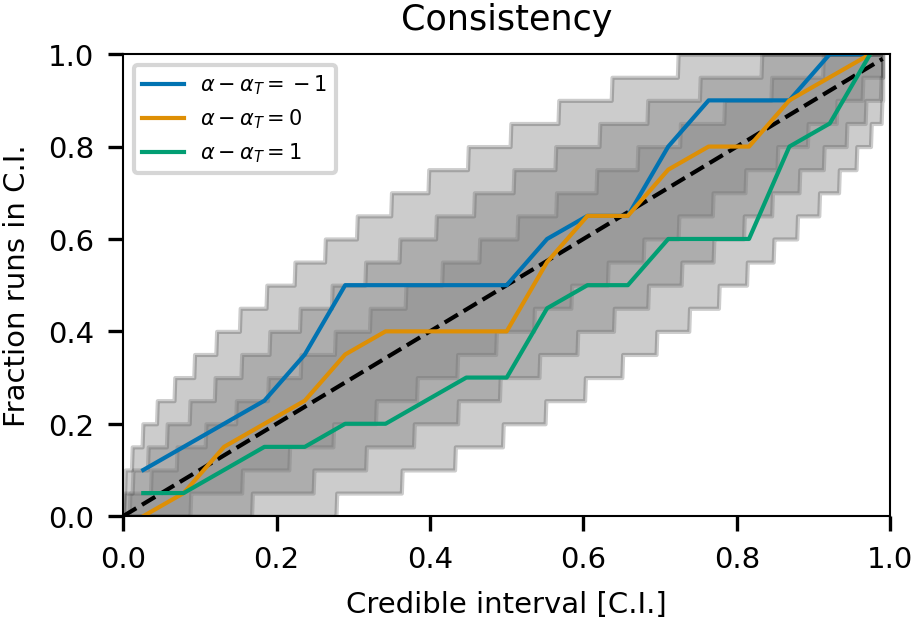

In [34]:
plt.figure(figsize=(3.3,2.0))

CI=np.linspace(0,0.99,1000)
plt.plot(CI,CI,ls='--',color='k')

plt.title('Consistency')


singlepos=pickle.load(open(filename[0],'rb'))
ppplot,ed=pp_curve_2(CI,singlepos,singlepos['H0_grid'],singlepos['true_H0'],plotsigma=True,Nevents=10)
plt.plot(ed,ppplot,color=pal[0],label=r'$\alpha - \alpha_T = -1%$')
ppplot

singlepos=pickle.load(open(filename[1],'rb'))
ppplot,ed=pp_curve_2(CI,singlepos,singlepos['H0_grid'],singlepos['true_H0'],plotsigma=False,Nevents=10)
plt.plot(ed,ppplot,color=pal[1],label=r'$\alpha - \alpha_T = 0%$')

singlepos=pickle.load(open(filename[2],'rb'))
ppplot,ed=pp_curve_2(CI,singlepos,singlepos['H0_grid'],singlepos['true_H0'],plotsigma=False,Nevents=10)
plt.plot(ed,ppplot,color=pal[2],label=r'$\alpha - \alpha_T = 1%$')


plt.legend(fontsize=5)
plt.xlabel(r'Credible interval [C.I.]')
plt.ylabel(r'Fraction runs in C.I.')
plt.xlim([0,1])
plt.ylim([0,1])

#plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GRAFICI/ppplot_mock.pdf')